# TFIDF Implementation

### Load Dependencies

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import wordnet

### Initial Setup

In [2]:
import os
os.chdir(r"D:\ironhack_bootcamp\main-bootcamp\week7\fake-news-detection-nlp")
os.getcwd()

'D:\\ironhack_bootcamp\\main-bootcamp\\week7\\fake-news-detection-nlp'

### Load Dataset

In [3]:
df = pd.read_csv(r"dataset\processed\clean_dataset.csv")
df.head()

,news_headline,label
0,donald trump sends embarrass new year eve mess...,0
1,drunk brag trump staffer start russian collusi...,0
2,sheriff david clarke become internet joke thre...,0
3,trump obsess even obama name cod website image,0
4,pope francis call donald trump christmas speech,0


In [4]:
df.isna().sum()

news_headline    0
label            0
dtype: int64

In [5]:
df.dropna(inplace= True)

In [6]:
X = df['news_headline']
y = df['label']

pd.set_option('display.max_colwidth', 350)
X.head()

0          donald trump sends embarrass new year eve message disturbing
1        drunk brag trump staffer start russian collusion investigation
2    sheriff david clarke become internet joke threaten poke people eye
3                        trump obsess even obama name cod website image
4                       pope francis call donald trump christmas speech
Name: news_headline, dtype: str

### Split Dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

X_train size: (27314,)
X_test size: (6829,)
y_train size: (27314,)
y_test size: (6829,)


### TFIDF Experiments

In [8]:
# Create empty DataFrame to store results
metrics_df=pd.DataFrame()

In [9]:
from utils.tfidf_vectorize import *
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = [
    LogisticRegression(), 
    LinearSVC(), 
    MultinomialNB(), 
    RandomForestClassifier(n_estimators= 500, max_depth= 10), 
    XGBClassifier(n_estimators= 500, max_depth= 10)
]
ngram_vals = [(1, 1), (1, 2), (1, 3), (2, 2)]
min_df_vals = [1, 10, 20]
max_df_vals = [0.90, 0.95, 0.99]

for model in models:
    for n in ngram_vals:
        for m in min_df_vals:
            for j in max_df_vals:

                row = run_tfidf_experiment(
                    model=model,
                    X_train=X_train,
                    X_test=X_test,
                    y_train=y_train,
                    y_test=y_test,
                    ngram_range=n,
                    min_df=m,
                    max_df=j,
                    comments=f"ngram={n}, min_df={m}, max_df={j}"
                )

                metrics_df = pd.concat(
                    [metrics_df, pd.DataFrame([row])],
                    ignore_index=True
                )

In [13]:
metrics_df.round(4).sort_values(by='test_f1', ascending= False)

,model,ngram_range,min_df,max_df,max_features,test_accuracy,train_f1,test_f1,gap_percent,comments
38,LinearSVC,"(1, 1)",1,0.99,10000,0.9326,0.9807,0.9314,4.94,"ngram=(1, 1), min_df=1, max_df=0.99"
36,LinearSVC,"(1, 1)",1,0.90,10000,0.9326,0.9807,0.9314,4.94,"ngram=(1, 1), min_df=1, max_df=0.9"
37,LinearSVC,"(1, 1)",1,0.95,10000,0.9326,0.9807,0.9314,4.94,"ngram=(1, 1), min_df=1, max_df=0.95"
45,LinearSVC,"(1, 2)",1,0.90,10000,0.9306,0.9838,0.9293,5.45,"ngram=(1, 2), min_df=1, max_df=0.9"
46,LinearSVC,"(1, 2)",1,0.95,10000,0.9306,0.9838,0.9293,5.45,"ngram=(1, 2), min_df=1, max_df=0.95"
...,...,...,...,...,...,...,...,...,...,...
138,RandomForestClassifier,"(2, 2)",10,0.90,10000,0.6083,0.3704,0.3593,1.12,"ngram=(2, 2), min_df=10, max_df=0.9"
139,RandomForestClassifier,"(2, 2)",10,0.95,10000,0.6080,0.3690,0.3573,1.17,"ngram=(2, 2), min_df=10, max_df=0.95"
143,RandomForestClassifier,"(2, 2)",20,0.99,10000,0.5999,0.3457,0.3385,0.72,"ngram=(2, 2), min_df=20, max_df=0.99"
142,RandomForestClassifier,"(2, 2)",20,0.95,10000,0.5999,0.3495,0.3372,1.23,"ngram=(2, 2), min_df=20, max_df=0.95"


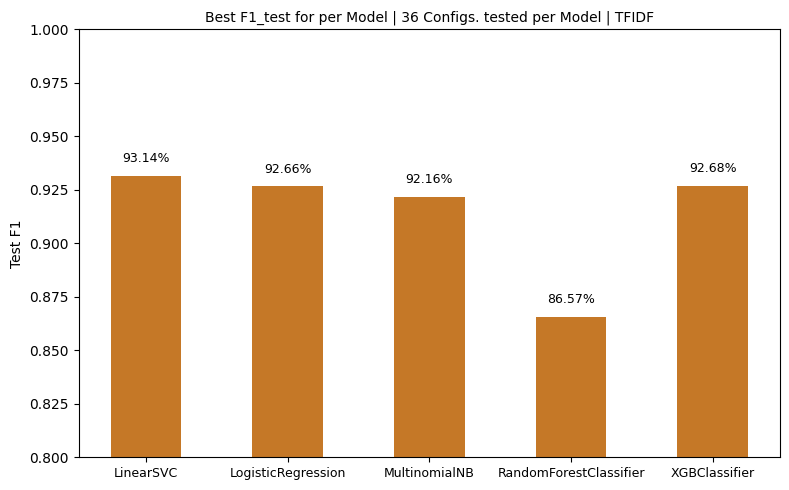

In [23]:
# Get best config per model
best_per_model =  metrics_df.sort_values("test_f1", ascending=False).groupby("model").first().reset_index()
total_configs = len(ngram_vals) * len(min_df_vals) * len(max_df_vals)
plt.figure(figsize=(8,5))

bars = plt.bar(
    best_per_model["model"],
    best_per_model["test_f1"],
    color = "#C57827",
    width= 0.5
)
plt.title(f"Best F1_test for per Model | {total_configs} Configs. tested per Model | TFIDF", fontsize = '10')
plt.xlabel("")
plt.ylabel("Test F1")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0, fontsize =9)

# Add values to labels 

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        f"{height*100:.2f}%",
        ha='center',
        va='bottom',
        fontsize= 9
    )
plt.tight_layout()

plt.show()

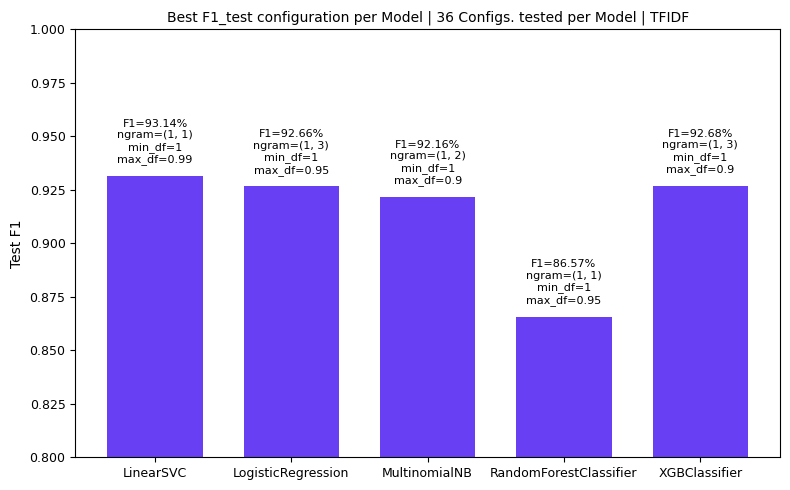

In [26]:
# Get best config per model
best_per_model = (
    metrics_df
    .sort_values("test_f1", ascending=False)
    .groupby("model")
    .first()
    .reset_index()
)

models = best_per_model["model"]
scores = best_per_model["test_f1"]

plt.figure(figsize=(8,5))

bars = plt.bar(
    models,
    scores,
    color="#693FF3",
    width = 0.7
)

plt.title(f"Best F1_test configuration per Model | {total_configs} Configs. tested per Model | TFIDF", fontsize = '10') 
plt.xlabel("")
plt.ylabel("Test F1")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0, fontsize =9 )
plt.yticks(fontsize= 9)

# Add value labels + best parameters
for i, bar in enumerate(bars):
    height = bar.get_height()
    
    label_text = (
        f"F1={height*100:.2f}%\n"
        f"ngram={best_per_model['ngram_range'][i]}\n"
        f"min_df={best_per_model['min_df'][i]}\n"
        f"max_df={best_per_model['max_df'][i]}"
    )
    
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        label_text,
        ha="center",
        va="bottom",
        fontsize=8
    )
plt.tight_layout()
plt.show()